## Problem Statement
**The objective of this analysis is to understand customer purchasing behavior and identify patterns
that impact revenue and customer risk. This exploratory analysis will support data-driven
decision-making for customer retention and revenue optimization.**


# Load & Understanding Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'C:\Users\srial\OneDrive\Desktop\ML_Projects\customer-sales-analysis\data\sales_data.csv')

df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    2000 non-null   int64  
 1   StockCode    2000 non-null   int64  
 2   Description  2000 non-null   object 
 3   Quantity     2000 non-null   int64  
 4   InvoiceDate  2000 non-null   object 
 5   UnitPrice    2000 non-null   float64
 6   CustomerID   2000 non-null   int64  
 7   Country      2000 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 125.1+ KB


,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,149313.431500,54325.041500,7.564500,26.109920,10509.075000
std,28850.208862,25896.627703,4.010846,13.765338,286.591227
min,100055.000000,10138.000000,1.000000,2.510000,10000.000000
25%,124200.500000,32139.500000,4.000000,14.112500,10259.000000
50%,149584.500000,54505.500000,7.500000,25.810000,10510.500000
75%,174445.750000,77034.750000,11.000000,38.422500,10762.000000
max,199986.000000,99963.000000,14.000000,49.970000,10998.000000


## Data Cleaning & Preparation
Raw transactional data often contains missing values and invalid records.
In this step, missing customer identifiers and invalid transactions were removed
to ensure accurate and unbiased analysis.


In [4]:
df.isnull().sum()

df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


## Feature Engineering
To enable meaningful analysis, new features such as total transaction value and time-based
attributes were created. These features help capture customer spending behavior and trends.


In [5]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day


**Core Business Insights**

**1.Top Customers**

In [7]:
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_customers


CustomerID
10058    2266.83
10463    1990.69
10532    1943.04
10572    1922.79
10890    1883.32
10416    1822.39
10426    1636.67
10073    1619.15
10888    1540.27
10642    1516.88
Name: TotalPrice, dtype: float64

**2.Country-wise Sales**

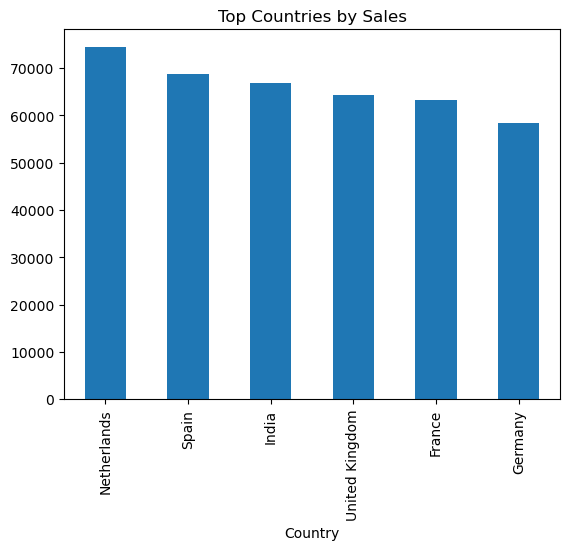

In [8]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
country_sales.plot(kind='bar', title='Top Countries by Sales')
plt.show()


**3.Monthly Sales Trend**

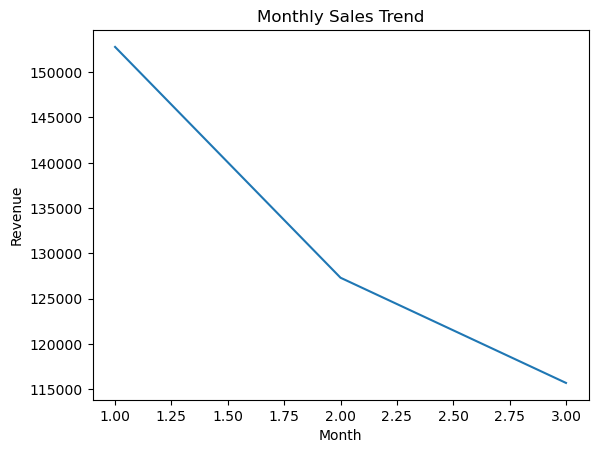

In [9]:
monthly_sales = df.groupby('Month')['TotalPrice'].sum()

plt.figure()
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()


## Customer Segmentation
Customers were segmented into High, Medium, and Low value groups based on their total revenue
contribution. This allows businesses to prioritize retention and engagement strategies.


In [10]:
customer_revenue = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()

customer_revenue['Segment'] = pd.qcut(
    customer_revenue['TotalPrice'],
    q=3,
    labels=['Low Value', 'Medium Value', 'High Value']
)

customer_revenue['Segment'].value_counts()


Segment
High Value      285
Low Value       284
Medium Value    284
Name: count, dtype: int64

## Customer Risk Profiling
Purchase frequency and revenue contribution were analyzed to identify churn-prone customers.
One-time and low-value customers were flagged as high risk due to low engagement.


**1.Repeat vs One-Time Customers (Risk Indicator)**

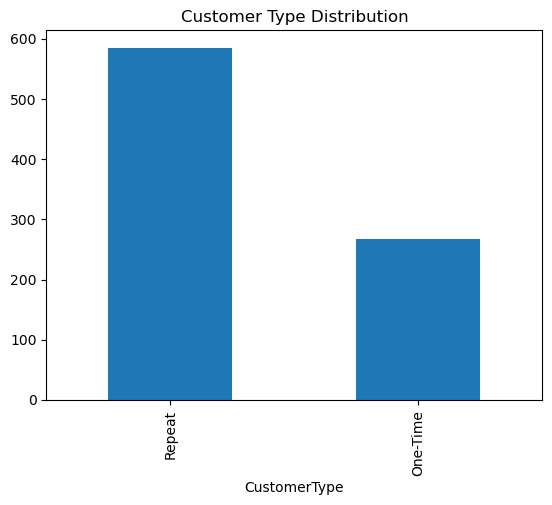

In [11]:
purchase_counts = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
purchase_counts.columns = ['CustomerID', 'PurchaseCount']

purchase_counts['CustomerType'] = purchase_counts['PurchaseCount'].apply(
    lambda x: 'One-Time' if x == 1 else 'Repeat'
)

purchase_counts['CustomerType'].value_counts().plot(kind='bar', title='Customer Type Distribution')
plt.show()


**2.Revenue Concentration Risk**

In [12]:
top_10_revenue = customer_revenue.sort_values(
    by='TotalPrice', ascending=False
).head(10)['TotalPrice'].sum()

total_revenue = customer_revenue['TotalPrice'].sum()

(top_10_revenue / total_revenue) * 100


4.583492310169784

**3.Low-Value + Low-Frequency Customers (Hidden Risk)**

In [13]:
risk_customers = purchase_counts.merge(customer_revenue, on='CustomerID')

high_risk = risk_customers[
    (risk_customers['CustomerType'] == 'One-Time') &
    (risk_customers['Segment'] == 'Low Value')
]

len(high_risk)


187

**Visual: Revenue by Segment**

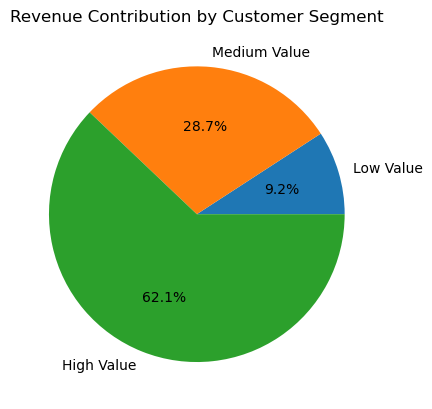

In [17]:
segment_revenue = customer_revenue.groupby('Segment',observed=True)['TotalPrice'].sum()

segment_revenue.plot(kind='pie', autopct='%1.1f%%', title='Revenue Contribution by Customer Segment')
plt.ylabel('')
plt.show()


# BUSINESS RECOMMENDATIONS

1.Introduce loyalty programs for high-value customers

2.Target medium-value customers with promotions to move them upward

3.Reduce acquisition cost for low-value, one-time customers

4.Diversify revenue sources to reduce dependency risk

## EDA Conclusion
The analysis revealed strong revenue concentration among a small group of customers and
highlighted churn risks among low-value, infrequent buyers. These insights formed the foundation
for predictive modeling in the next phase.
